# XGBRegressor to predict participant Brier scores

## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wordninja
import xgboost as xgb

# Local imports
from src import process
from src import plot
from src import util

data_path = process.DEFAULT_DATA_PATH

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
markets_df = process.get_current_probs()
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
blind_mode_df["brier_score"] = brier_score

Loading current probabilities from file


## XGB Regressor to predict Brier score

In [4]:
# Use xgboost to predict the brier score from the other columns

# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_xgboost = blind_mode_feature_df[columns_to_use]
blind_mode_df_xgboost.head()

# Remove rows with NaNs
# blind_mode_df_xgboost.dropna(inplace=True)
# blind_mode_df_xgboost.shape

# Create the X and y arrays
X = blind_mode_df_xgboost
# Assign the column names to the X array
y = blind_mode_df["brier_score"]

# Split into train and test sets
random_seed = np.random.randint(100000)
random_seed = 1337
print(f"Random seed: {random_seed}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed, test_size=0.2
)

# Create the xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

Random seed: 1337


0.0021330110037029197

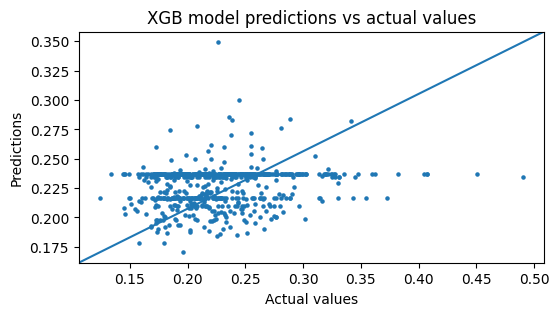

In [5]:
# XGBoost model predictions vs actual values
display(mean_squared_error(y_test, y_pred))
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, s=5)
ax.set_title("XGB model predictions vs actual values")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predictions")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()

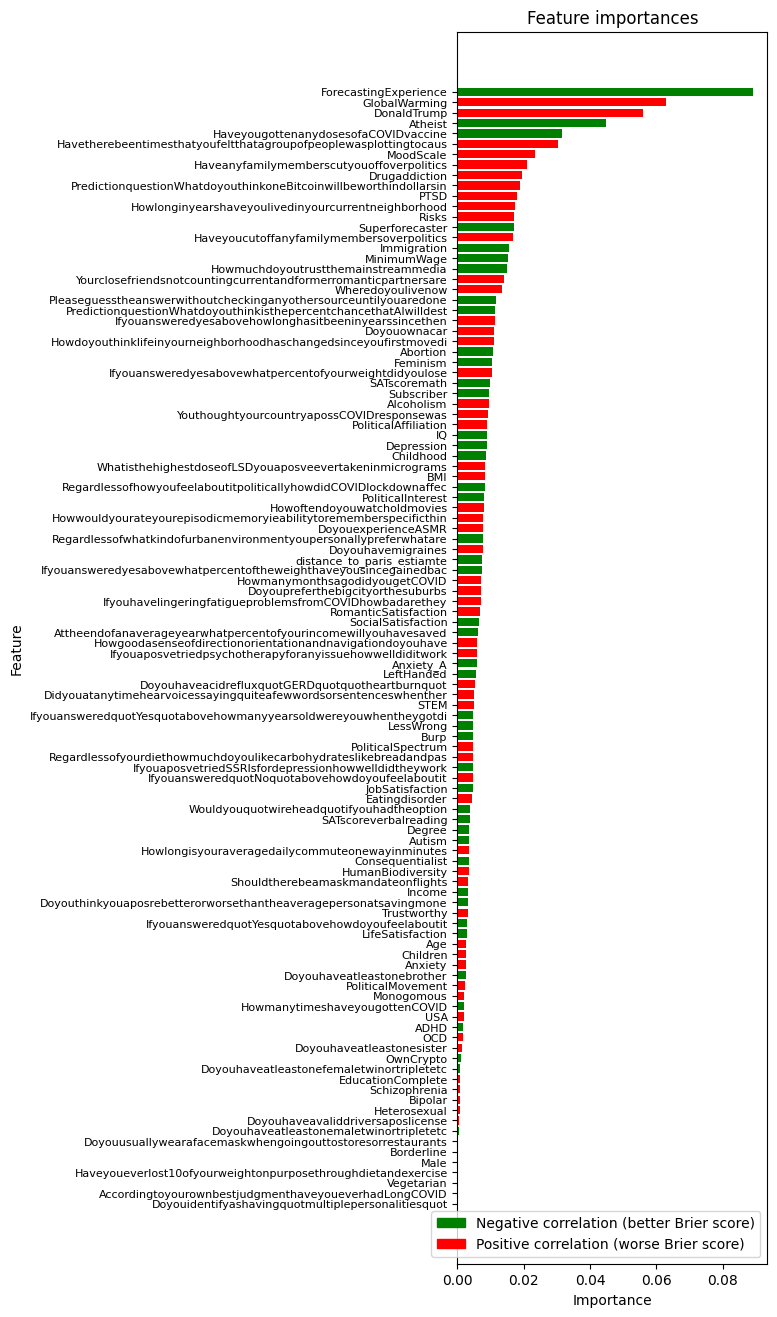

In [6]:
# Feature importance for the XGBoost model

# Get the feature importances
feature_importances = xgb_model.feature_importances_
feature_names = blind_mode_df_xgboost.columns
# Get the correlation of each feature with the brier score
feature_correlations = blind_mode_df_xgboost.corrwith(blind_mode_df["brier_score"])
colors = np.array(["green" if x < 0 else "red" for x in feature_correlations])

fig = plt.figure(figsize=(4, 16))
ax = fig.add_subplot(111)
ax.barh(
    feature_names[feature_importances.argsort()],
    feature_importances[feature_importances.argsort()],
    color=colors[feature_importances.argsort()],
)
ax.set_title("Feature importances")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.yticks(rotation=0)
# Add color legend
green_patch = mpatches.Patch(
    color="green", label="Negative correlation (better Brier score)"
)
red_patch = mpatches.Patch(
    color="red", label="Positive correlation (worse Brier score)"
)
ax.tick_params(axis="y", which="major", labelsize=8)
plt.legend(handles=[green_patch, red_patch], loc="lower right")
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


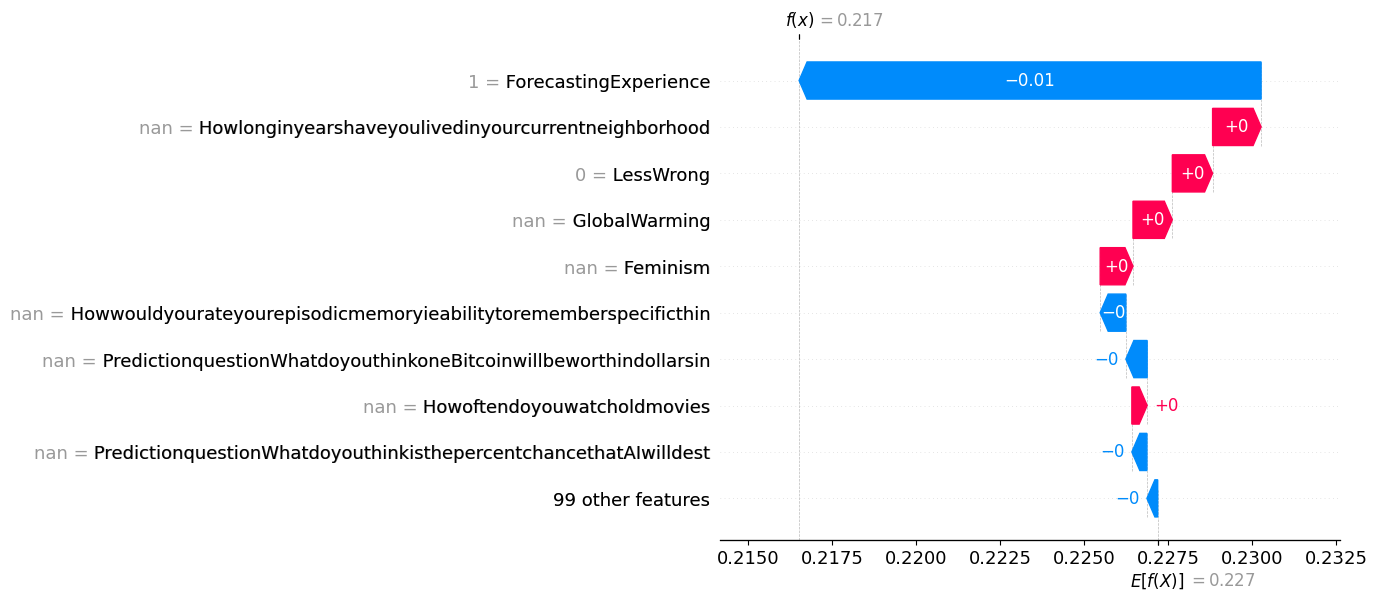

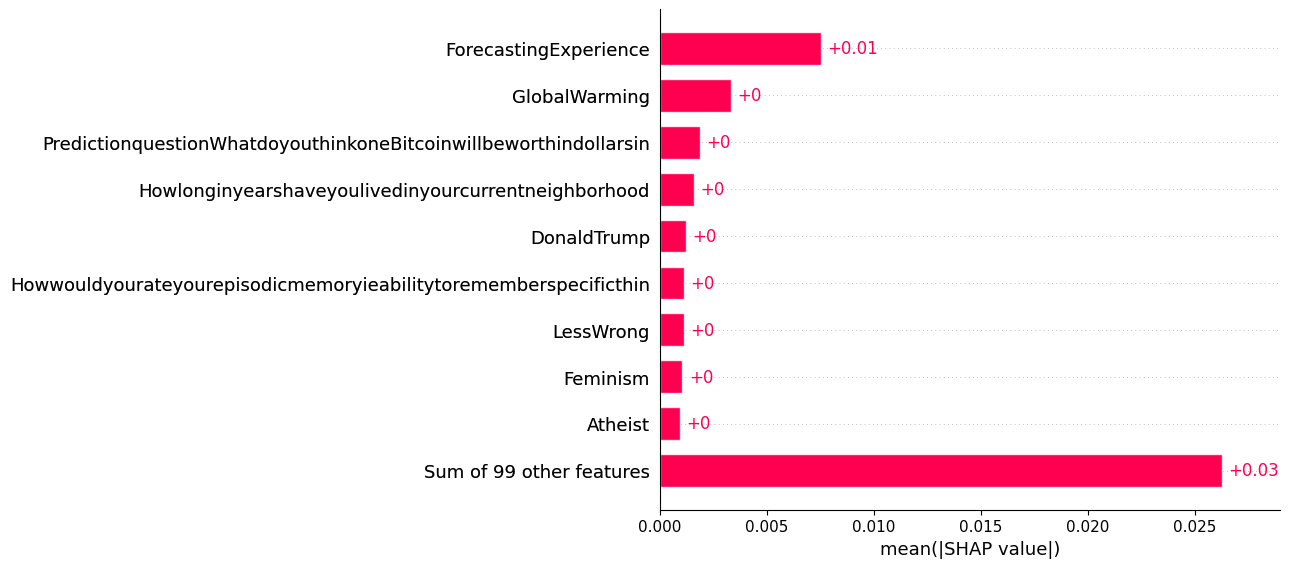

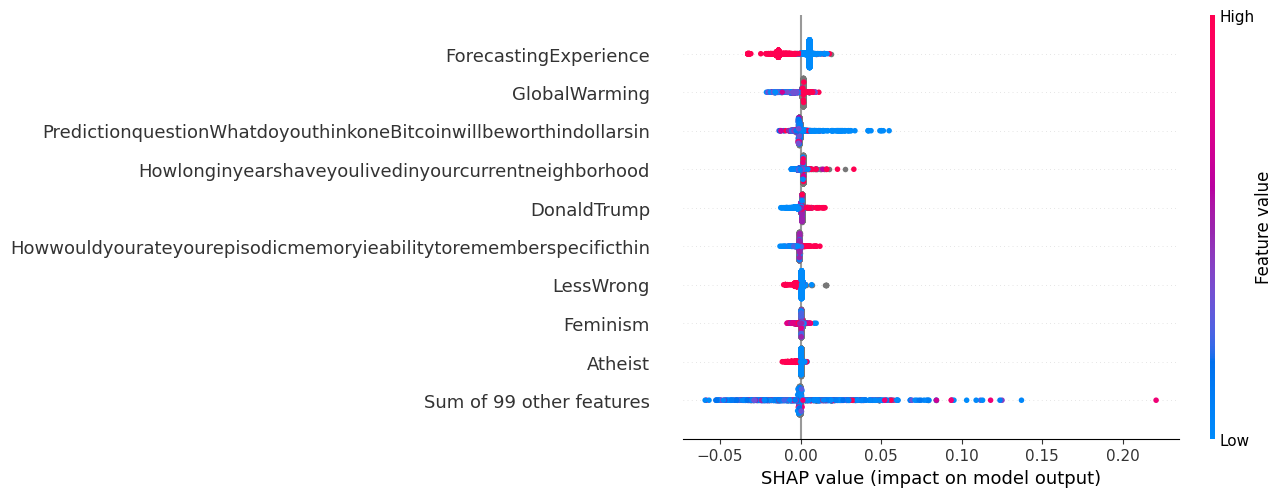

In [7]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

In [8]:
# Sort features by their correlation with the brier score
display(blind_mode_df_xgboost.corrwith(blind_mode_df["brier_score"]).sort_values())

Immigration                                                        -0.217604
Regardlessofwhatkindofurbanenvironmentyoupersonallypreferwhatare   -0.199642
SATscoremath                                                       -0.195645
Howmuchdoyoutrustthemainstreammedia                                -0.174209
ForecastingExperience                                              -0.169945
                                                                      ...   
Howlonginyearshaveyoulivedinyourcurrentneighborhood                 0.135328
Age                                                                 0.157794
GlobalWarming                                                       0.181911
PoliticalAffiliation                                                0.182136
DonaldTrump                                                         0.219501
Length: 108, dtype: float64

Random seed: 1337


0.0021266805445375107

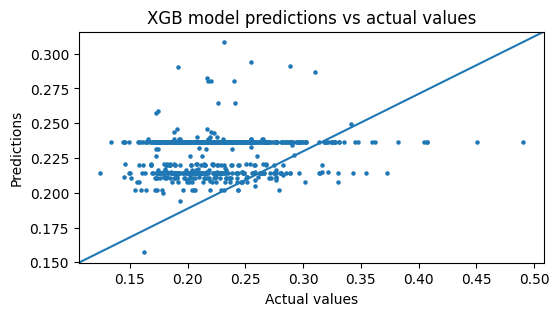

In [9]:
# Train a new XGBRegressor model, but remove the features with the bottom half
# of feature importances

# Get the feature importances
feature_importances = xgb_model.feature_importances_
feature_names = blind_mode_feature_df.columns

# Get the indices of the features sorted by importance
sorted_indices = feature_importances.argsort()
# Get the indices of the features sorted by importance, but only the top frac_to_keep
n_features_to_keep = 5
top_half_indices = sorted_indices[-n_features_to_keep:]
top_half_features_sorted = feature_names[top_half_indices]

# Create a new dataframe with the columns we want to use
columns_to_use = top_half_features_sorted.tolist()
subset_df_xgboost = blind_mode_feature_df[columns_to_use]

# Train a model as above, but with the subset of features
# Create the X and y arrays
X = subset_df_xgboost
y = blind_mode_df["brier_score"]

# Split into train and test sets
random_seed = np.random.randint(100000)
random_seed = 1337
print(f"Random seed: {random_seed}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed, test_size=0.2
)

# Create the xgboost model
xgb_model_subset = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Fit the model
xgb_model_subset.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model_subset.predict(X_test)

# XGBoost model predictions vs actual values
display(mean_squared_error(y_test, y_pred))

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, s=5)
ax.set_title("XGB model predictions vs actual values")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predictions")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()

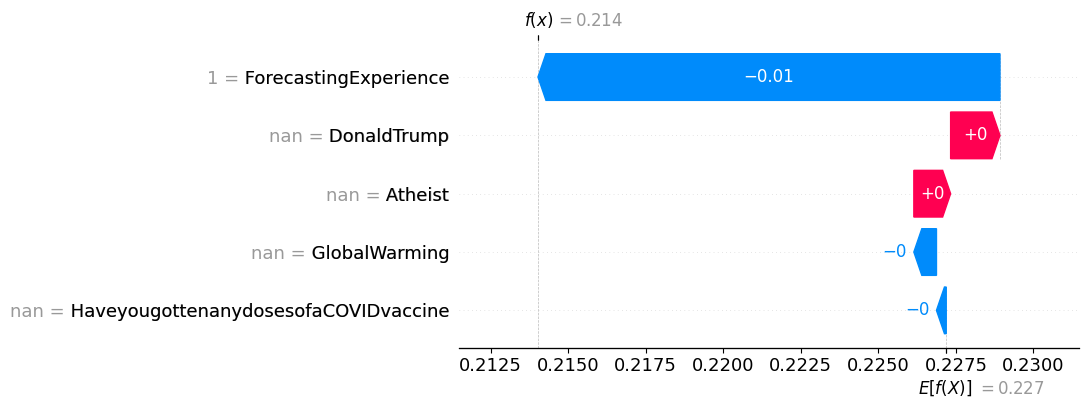

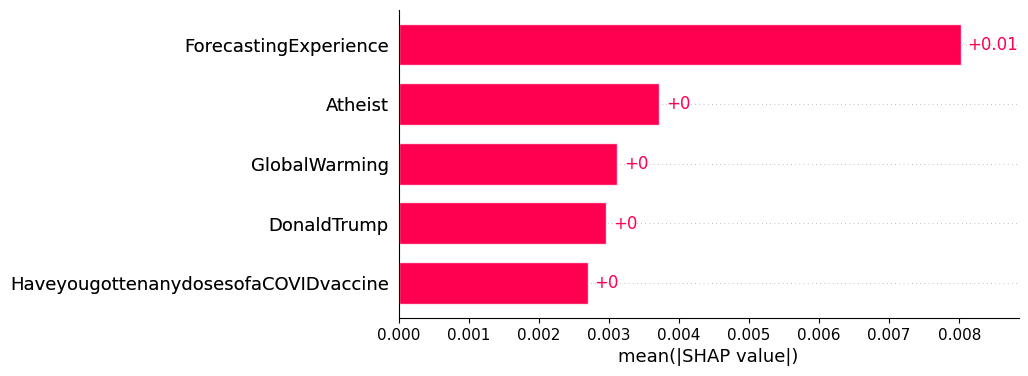

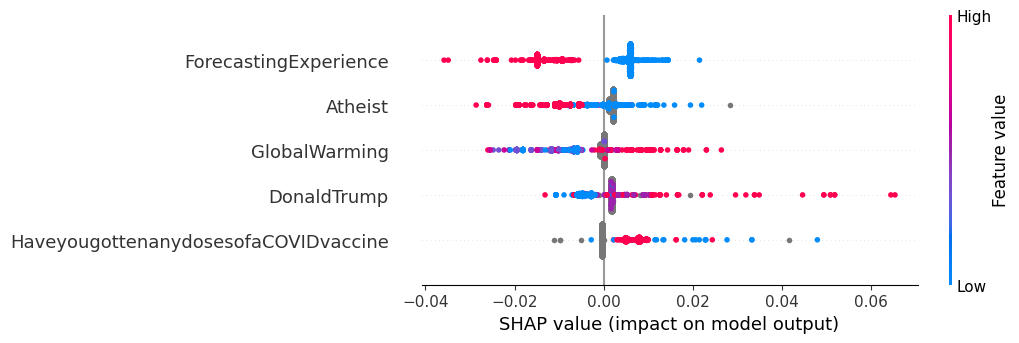

In [10]:
# Shap of the subset model

explainer = shap.Explainer(xgb_model_subset)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

## XGB Regressor for prediction aggregation

In [11]:
# Split data into features (demographic data) and target (actual outcomes)
demographic_features = blind_mode_df_xgboost.values
participant_scores = blind_mode_df["brier_score"].values

rng_seeds = [42, 1337]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, ests_train, ests_test = train_test_split(
    demographic_features,
    participant_scores,
    estimates_matrix,
    random_state=rng_seeds[0],
    test_size=0.5,
)

# Create the xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=rng_seeds[1])

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
display(mean_squared_error(y_test, y_pred))

0.0022078239391719904

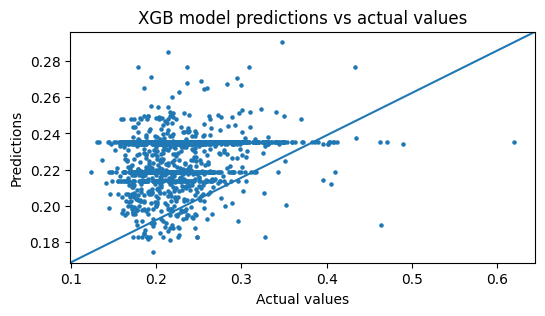

In [12]:
# Plot scatter of predictions vs actual values
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, s=5)
ax.set_title("XGB model predictions vs actual values")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predictions")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()

In [13]:
# Run aggregation on test from above
y_pred_train = xgb_model.predict(X_train)
participant_weight_train = y_pred_train / y_pred_train.sum()
aggregate_predictions_train = np.dot(ests_train.transpose(), participant_weight_train)
aggregated_mse_train = mean_squared_error(
    aggregate_predictions_train, resolution_vector
)
print(f"Mean Squared Error of test Aggregated Predictions: {aggregated_mse_train}")

Mean Squared Error of test Aggregated Predictions: 0.17679566948339812


In [14]:
# Do same, but for test
y_pred_test = xgb_model.predict(X_test)
participant_weight_test = y_pred_test / y_pred_test.sum()
aggregate_predictions_test = np.dot(ests_test.transpose(), participant_weight_test)
aggregated_mse_test = mean_squared_error(aggregate_predictions_test, resolution_vector)
print(f"Mean Squared Error of test Aggregated Predictions: {aggregated_mse_test}")

Mean Squared Error of test Aggregated Predictions: 0.17641911594984142


In [15]:
# Find mse from the single best y_pred_test
# TODO verify that this is actually much worse than the aggregated predictions
best_y_pred_test = ests_test[np.argmax(y_pred_test), :]
best_mse = mean_squared_error(best_y_pred_test, resolution_vector)
print(f"Mean Squared Error of test best prediction: {best_mse}")

Mean Squared Error of test best prediction: 0.34758


In [16]:
# Same as above, but extremize the participant weights with softmax
softmax_temperature = 0.1
participant_weights_test_softmax = util.softmax(
    participant_weight_test, softmax_temperature
)
aggregated_predictions_test_softmax = np.dot(
    ests_test.transpose(), participant_weights_test_softmax
)
mse_softmax = mean_squared_error(aggregated_predictions_test_softmax, resolution_vector)
print(f"Mean Squared Error of test Aggregated Predictions: {mse_softmax}")

Mean Squared Error of test Aggregated Predictions: 0.17618441849088984


In [17]:
# Check MSE from using beta transformation on aggregate_predictions_test
beta_a = 1 / 3
beta_b = beta_a
mse_beta = mean_squared_error(
    beta.ppf(aggregated_predictions_test_softmax, beta_a, beta_b), resolution_vector
)
print(f"Mean Squared Error of test Aggregated Predictions: {mse_beta}")

Mean Squared Error of test Aggregated Predictions: 0.1629845890086104
